# 環境構築

In [4]:
!pip -q install folium==0.2.1
!pip -q install  pytorch_lightning
!pip -q install  torchmetrics
!pip install -q japanize_matplotlib

     |████████████████████████████████| 69 kB 3.6 MB/s 
     |████████████████████████████████| 527 kB 5.4 MB/s 
     |████████████████████████████████| 397 kB 48.6 MB/s 
     |████████████████████████████████| 952 kB 41.2 MB/s 
     |████████████████████████████████| 596 kB 38.3 MB/s 
     |████████████████████████████████| 134 kB 39.8 MB/s 
     |████████████████████████████████| 829 kB 44.9 MB/s 
     |████████████████████████████████| 1.1 MB 39.9 MB/s 
     |████████████████████████████████| 94 kB 1.0 MB/s 
     |████████████████████████████████| 144 kB 52.5 MB/s 
     |████████████████████████████████| 271 kB 54.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
     |████████████████████████████████| 4.1 MB 5.4 MB/s 


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
sns.set()
from sklearn.cluster import KMeans
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision import datasets
import pytorch_lightning as pl
import torchmetrics
from torchmetrics.functional import accuracy
import torchsummary # モデル構造の確認
from torchsummary import summary
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

%matplotlib inline
plt.style.use('bmh')

plt.rcParams['figure.figsize'] = 10, 10

#
ポルトガルのある銀行のダイレクトマーケティングキャンペーンに関連したデータセット

# 背景 
顧客にダイレクトマーケティング（電話）をかけると1件辺り500円ほどのコストが発生するため、なるべく**確度の高い顧客のに当たりをつけてダイレクトマーケティング（電話）したい**と考えています。
> キャンペーンの結果、どの顧客が定期預金を申し込むかどうかを予測するモデル

> Recall（再現率）重視


# データの前処理

## データの読み込み

### 訓練データ

In [6]:
df_train_val = pd.read_csv('/content/bank_train.csv')

In [7]:
df_train_val.head(2)

,age,job,marital,education,default,balance,housing,loan,pdays,previous,poutcome,result
0,50.0,entrepreneur,married,secondary,no,1857,no,yes,-1.0,0,unknown,fail
1,37.0,technician,single,secondary,no,363,yes,no,-1.0,0,unknown,fail


In [8]:
df_train_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6416 entries, 0 to 6415
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        6326 non-null   float64
 1   job        6413 non-null   object 
 2   marital    6327 non-null   object 
 3   education  6416 non-null   object 
 4   default    6387 non-null   object 
 5   balance    6416 non-null   int64  
 6   housing    6355 non-null   object 
 7   loan       6199 non-null   object 
 8   pdays      6380 non-null   float64
 9   previous   6416 non-null   int64  
 10  poutcome   6166 non-null   object 
 11  result     6416 non-null   object 
dtypes: float64(2), int64(2), object(8)
memory usage: 601.6+ KB


In [9]:
# 欠損値の数を確認
df_train_val.isnull().sum()

age           90
job            3
marital       89
education      0
default       29
balance        0
housing       61
loan         217
pdays         36
previous       0
poutcome     250
result         0
dtype: int64

In [10]:
df_train_val.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,6326.0,NaN,NaN,NaN,40.980398,10.612138,18.0,33.0,39.0,49.0,93.0
job,6413,12,blue-collar,1438,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital,6327,3,married,3839,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education,6416,4,secondary,3295,NaN,NaN,NaN,NaN,NaN,NaN,NaN
default,6387,2,no,6261,NaN,NaN,NaN,NaN,NaN,NaN,NaN
balance,6416.0,NaN,NaN,NaN,1329.53616,2711.424072,-3313.0,75.0,473.0,1463.25,43074.0
housing,6355,2,yes,3499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan,6199,2,no,5174,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pdays,6380.0,NaN,NaN,NaN,39.616458,97.74522,-1.0,-1.0,-1.0,-1.0,838.0
previous,6416.0,NaN,NaN,NaN,0.57341,1.955045,0.0,0.0,0.0,0.0,55.0


### テストデータ

In [11]:
test = pd.read_csv('/content/bank_test02.csv')

In [12]:
test.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,14965.0,NaN,NaN,NaN,40.957701,10.618818,18.0,33.0,39.0,48.0,95.0
job,14992,12,blue-collar,3230,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital,14955,3,married,9023,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education,15000,4,secondary,7645,NaN,NaN,NaN,NaN,NaN,NaN,NaN
default,14938,2,no,14650,NaN,NaN,NaN,NaN,NaN,NaN,NaN
balance,15000.0,NaN,NaN,NaN,1359.1116,2975.221144,-6847.0,71.0,447.0,1409.25,66721.0
housing,14886,2,yes,8157,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan,14976,2,no,12551,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pdays,14921.0,NaN,NaN,NaN,41.122914,100.577961,-1.0,-1.0,-1.0,-1.0,838.0
previous,15000.0,NaN,NaN,NaN,0.565267,1.753077,0.0,0.0,0.0,0.0,29.0


In [13]:
df_train_val.shape

(6416, 12)

## 重複行の削除

### 訓練データ

In [14]:
df_train_val.duplicated(keep=False)

0       False
1       False
2       False
3       False
4       False
        ...  
6411    False
6412    False
6413    False
6414    False
6415    False
Length: 6416, dtype: bool

In [15]:
df_train_val.duplicated(keep=False).value_counts()

False    6357
True       59
dtype: int64

In [16]:
df_train_val = df_train_val.drop_duplicates()

## 欠損値の処理

### 訓練データ

In [17]:
df_train_val = df_train_val.drop(['poutcome'], axis=1) # デフォルト(axis=0)で行方向に削除、axis=1で列方向に削除

In [18]:
df_train_val.shape

(6384, 11)

In [19]:
df_train_val = df_train_val.drop(['job'], axis=1)

In [20]:
df_train_val.shape

(6384, 10)

In [21]:
df_train_val = df_train_val.dropna(subset=['default'], axis=0)

In [22]:
df_train_val.shape

(6355, 10)

In [23]:
df_train_val = df_train_val.dropna(subset=['housing'], axis=0)

In [24]:
df_train_val['marital'].unique()

array(['married', 'single', 'divorced', nan], dtype=object)

In [25]:
df_train_val.shape

(6294, 10)

In [26]:
df_train_val = df_train_val.dropna(subset=['marital'], axis=0)

In [27]:
df_train_val.shape

(6207, 10)

In [28]:
df_train_val = df_train_val.fillna({'pdays':-1})

In [29]:
df_train_val.shape

(6207, 10)

In [30]:
df_train_val = df_train_val.fillna({'age':df_train_val['age'].mean()})

In [31]:
df_train_val['loan'].mode()[0]

'no'

In [32]:
df_train_val = df_train_val.fillna({'loan':df_train_val['loan'].mode()[0]})

In [33]:
# 欠損値の数を確認
df_train_val.isnull().sum()

age          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
pdays        0
previous     0
result       0
dtype: int64

In [34]:
df_train_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6207 entries, 0 to 6415
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        6207 non-null   float64
 1   marital    6207 non-null   object 
 2   education  6207 non-null   object 
 3   default    6207 non-null   object 
 4   balance    6207 non-null   int64  
 5   housing    6207 non-null   object 
 6   loan       6207 non-null   object 
 7   pdays      6207 non-null   float64
 8   previous   6207 non-null   int64  
 9   result     6207 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 533.4+ KB


### テストデータ

In [35]:
# 欠損値の数を確認
test.isnull().sum()

age           35
job            8
marital       45
education      0
default       62
balance        0
housing      114
loan          24
pdays         79
previous       0
poutcome     152
result         0
dtype: int64

In [36]:
test = test.drop(['poutcome'], axis=1)

In [37]:
test = test.drop(['job'], axis=1)

In [38]:
test = test.fillna({'default':df_train_val['default'].mode()[0]})

In [39]:
test = test.fillna({'housing':df_train_val['housing'].mode()[0]})

In [40]:
test = test.fillna({'marital':df_train_val['marital'].mode()[0]})

In [41]:
test = test.fillna({'pdays':-1})

In [42]:
test = test.fillna({'age':df_train_val['age'].mean()})

In [43]:
test = test.fillna({'loan':df_train_val['loan'].mode()[0]})

In [44]:
# 欠損値の数を確認
test.isnull().sum()

age          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
pdays        0
previous     0
result       0
dtype: int64

In [45]:
df_train_val.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,6207.0,NaN,NaN,NaN,41.026311,10.559919,18.0,33.0,39.0,48.0,93.0
marital,6207,3,married,3763,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education,6207,4,secondary,3196,NaN,NaN,NaN,NaN,NaN,NaN,NaN
default,6207,2,no,6085,NaN,NaN,NaN,NaN,NaN,NaN,NaN
balance,6207.0,NaN,NaN,NaN,1344.13372,2739.348891,-3313.0,78.5,478.0,1481.5,43074.0
housing,6207,2,yes,3407,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan,6207,2,no,5210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pdays,6207.0,NaN,NaN,NaN,39.344611,97.383104,-1.0,-1.0,-1.0,-1.0,838.0
previous,6207.0,NaN,NaN,NaN,0.573385,1.961699,0.0,0.0,0.0,0.0,55.0
result,6207,2,fail,5487,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
df_train_val.shape

(6207, 10)

In [47]:
df_train_val.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,6207.0,NaN,NaN,NaN,41.026311,10.559919,18.0,33.0,39.0,48.0,93.0
marital,6207,3,married,3763,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education,6207,4,secondary,3196,NaN,NaN,NaN,NaN,NaN,NaN,NaN
default,6207,2,no,6085,NaN,NaN,NaN,NaN,NaN,NaN,NaN
balance,6207.0,NaN,NaN,NaN,1344.13372,2739.348891,-3313.0,78.5,478.0,1481.5,43074.0
housing,6207,2,yes,3407,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan,6207,2,no,5210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pdays,6207.0,NaN,NaN,NaN,39.344611,97.383104,-1.0,-1.0,-1.0,-1.0,838.0
previous,6207.0,NaN,NaN,NaN,0.573385,1.961699,0.0,0.0,0.0,0.0,55.0
result,6207,2,fail,5487,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## カテゴリカル変数の数値化

### 訓練データ

In [48]:
# カテゴリカル変数を含んだデータのみ抽出
df_obj = df_train_val.select_dtypes(include='object')
df_obj.head(3)

,marital,education,default,housing,loan,result
0,married,secondary,no,no,yes,fail
1,single,secondary,no,yes,no,fail
2,married,primary,no,yes,no,fail


In [49]:
df_uni = df_obj.nunique()
df_uni

marital      3
education    4
default      2
housing      2
loan         2
result       2
dtype: int64

In [50]:
for uni in df_obj.columns:
    print(uni)
    print(df_obj[uni].unique())

marital
['married' 'single' 'divorced']
education
['secondary' 'primary' 'tertiary' 'unknown']
default
['no' 'yes']
housing
['no' 'yes']
loan
['yes' 'no']
result
['fail' 'success']


#### Label Encoding

In [51]:
# モデルの宣言
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# モデルの学習
le.fit(df_train_val['default'])

# 適用
df_train_val['default'] = le.transform(df_train_val['default'])

In [52]:
le.classes_

array(['no', 'yes'], dtype=object)

In [53]:
# モデルの宣言
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# モデルの学習
le.fit(df_train_val['housing'])

# 適用
df_train_val['housing'] = le.transform(df_train_val['housing'])

In [54]:
le.classes_

array(['no', 'yes'], dtype=object)

In [55]:
# モデルの宣言
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# モデルの学習
le.fit(df_train_val['loan'])

# 適用
df_train_val['loan'] = le.transform(df_train_val['loan'])

In [56]:
le.classes_

array(['no', 'yes'], dtype=object)

In [57]:
# モデルの宣言
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# モデルの学習
le.fit(df_train_val['result'])

# 適用
df_train_val['result'] = le.transform(df_train_val['result'])

In [58]:
le.classes_

array(['fail', 'success'], dtype=object)

#### One Hot Encoding

In [59]:
df_train_val.head()

,age,marital,education,default,balance,housing,loan,pdays,previous,result
0,50.0,married,secondary,0,1857,0,1,-1.0,0,0
1,37.0,single,secondary,0,363,1,0,-1.0,0,0
2,35.0,married,primary,0,422,1,0,-1.0,0,0
3,55.0,married,secondary,0,119,0,1,-1.0,0,0
4,40.0,single,secondary,0,1066,1,0,-1.0,0,0


In [60]:
df_train_val = pd.get_dummies(df_train_val, drop_first=True)

In [61]:
df_train_val.shape

(6207, 13)

In [62]:
df_train_val.head(79)

,age,default,balance,housing,loan,pdays,previous,result,marital_married,marital_single,education_secondary,education_tertiary,education_unknown
0,50.0,0,1857,0,1,-1.0,0,0,1,0,1,0,0
1,37.0,0,363,1,0,-1.0,0,0,0,1,1,0,0
2,35.0,0,422,1,0,-1.0,0,0,1,0,0,0,0
3,55.0,0,119,0,1,-1.0,0,0,1,0,1,0,0
4,40.0,0,1066,1,0,-1.0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,25.0,0,1235,1,1,349.0,3,0,0,1,1,0,0
80,40.0,0,390,0,0,-1.0,0,0,0,0,0,1,0
81,30.0,0,-218,1,0,-1.0,0,0,0,1,0,1,0
83,32.0,0,127,0,0,-1.0,0,0,0,1,0,1,0


### テストデータ

In [63]:
# カテゴリカル変数を含んだデータのみ抽出
df_obj_test = test.select_dtypes(include='object')
df_obj_test.head(3)

,marital,education,default,housing,loan,result
0,married,tertiary,no,yes,no,fail
1,married,tertiary,no,yes,no,fail
2,married,secondary,no,no,yes,success


In [64]:
df_uni_test = df_obj_test.nunique()
df_uni_test

marital      3
education    4
default      2
housing      2
loan         2
result       2
dtype: int64

In [65]:
for uni in df_obj_test.columns:
    print(uni)
    print(df_obj_test[uni].unique())

marital
['married' 'divorced' 'single']
education
['tertiary' 'secondary' 'primary' 'unknown']
default
['no' 'yes']
housing
['yes' 'no']
loan
['no' 'yes']
result
['fail' 'success']


#### Label Encoding

In [66]:
# モデルの宣言
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# モデルの学習
le.fit(test['default'])

# 適用
test['default'] = le.transform(test['default'])

In [67]:
le.classes_

array(['no', 'yes'], dtype=object)

In [68]:
# モデルの宣言
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# モデルの学習
le.fit(test['housing'])

# 適用
test['housing'] = le.transform(test['housing'])

In [69]:
le.classes_

array(['no', 'yes'], dtype=object)

In [70]:
# モデルの宣言
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# モデルの学習
le.fit(test['loan'])

# 適用
test['loan'] = le.transform(test['loan'])

In [71]:
le.classes_

array(['no', 'yes'], dtype=object)

In [72]:
# モデルの宣言
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# モデルの学習
le.fit(test['result'])

# 適用
test['result'] = le.transform(test['result'])

In [73]:
le.classes_

array(['fail', 'success'], dtype=object)

In [74]:
test.head(1)

,age,marital,education,default,balance,housing,loan,pdays,previous,result
0,55.0,married,tertiary,0,1810,1,0,-1.0,0,0


#### One Hot Encoding

In [75]:
test = pd.get_dummies(test, drop_first=True)

In [76]:
test.shape

(15000, 13)

# モデルの実装
- 最終的にはPyTorch を用いたモデルを採用した

In [ ]:
x = df_train_val.drop('result', axis=1).values
t = df_train_val['result'].values

print(x.shape, t.shape)

(6207, 12) (6207,)


In [ ]:
# 学習データと検証データの分割
from sklearn.model_selection import train_test_split
x_train, x_val, t_train, t_val = train_test_split(x, t, test_size=0.3, random_state=0)

In [ ]:
x_test = test.drop('result', axis=1).values
t_test = test['result'].values

print(x_test.shape, t_test.shape)

(15000, 12) (15000,)


## SMOTE を用いての OverSampling

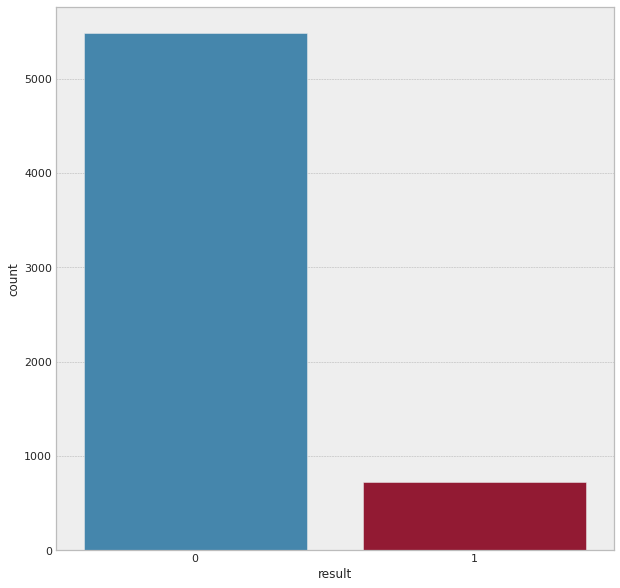

In [ ]:
sns.countplot(df_train_val['result'])

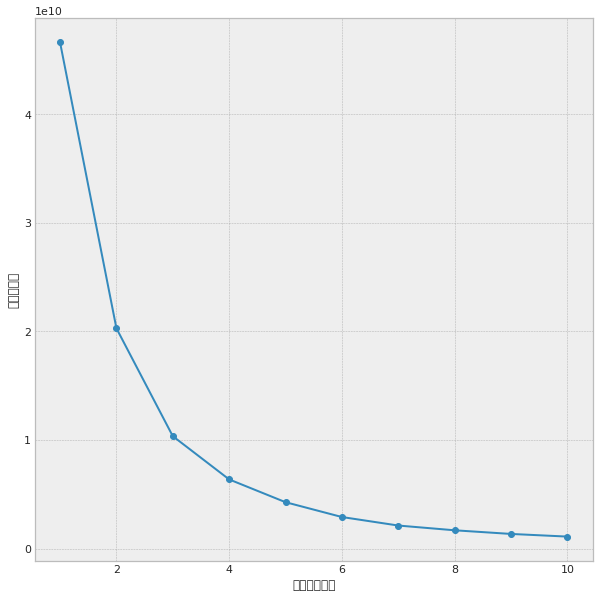

In [ ]:
distortions = []

for i  in range(1,11):                # 1~10クラスタまで一気に計算 
    km = KMeans(n_clusters=i,
                n_init=10,
                random_state=0)
    km.fit(x)                         # クラスタリングの計算を実行
    distortions.append(km.inertia_)   # km.fitするとkm.inertia_が得られる

plt.figure(figsize=(10, 10))
plt.plot(range(1,11),distortions,marker='o')
plt.xlabel('クラスタの数')
plt.ylabel('誤差の総和')
plt.show()

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0, k_neighbors=2) # k_neighbors：利用するKの近傍点の数

In [ ]:
x_train_val_oversampled, t_train_val_oversampled = smote.fit_resample(x, t)
x_train_oversampled, t_train_oversampled = smote.fit_resample(x_train, t_train)
x_val_oversampled, t_val_oversampled = smote.fit_resample(x_val, t_val)

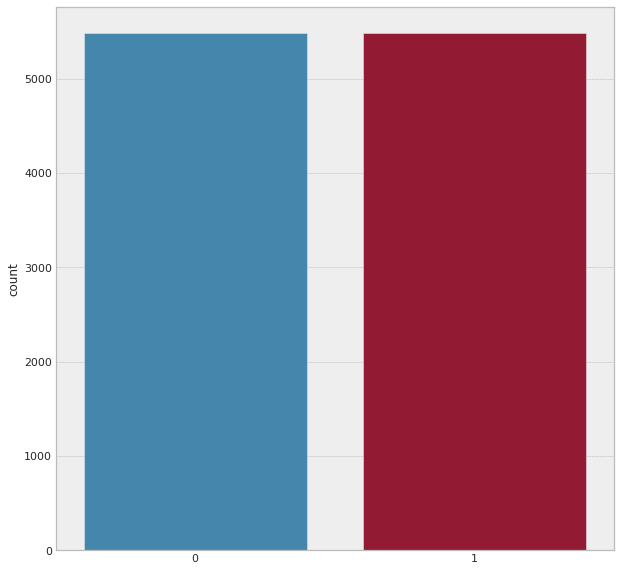

In [ ]:
# クラス１のデータ数が、クラス０のデータ数と同じになりことを確認
sns.countplot(t_train_val_oversampled)

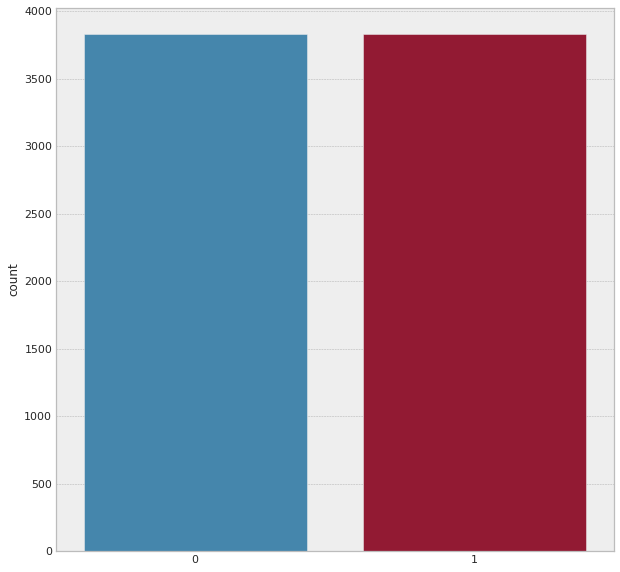

In [ ]:
# クラス１のデータ数が、クラス０のデータ数と同じになりことを確認
sns.countplot(t_train_oversampled)

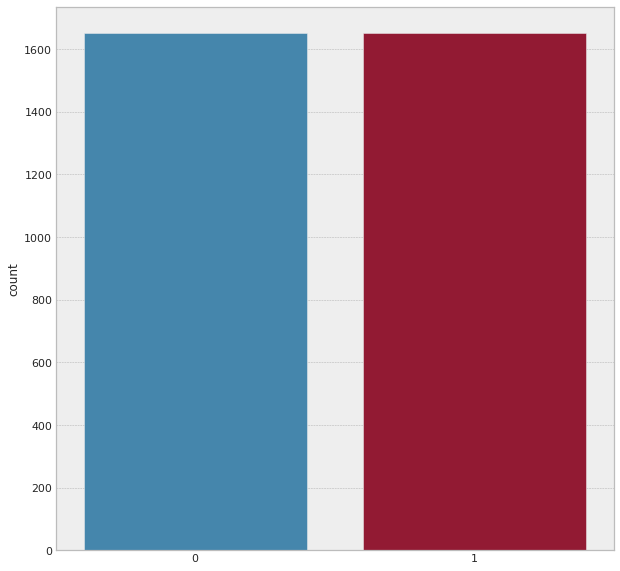

In [ ]:
# クラス１のデータ数が、クラス０のデータ数と同じになりことを確認
sns.countplot(t_val_oversampled)

## 重回帰分析

In [ ]:
df_train_val.head(2)

,age,default,balance,housing,loan,pdays,previous,result,marital_married,marital_single,education_secondary,education_tertiary,education_unknown
0,50.0,0,1857,0,1,-1.0,0,0,1,0,1,0,0
1,37.0,0,363,1,0,-1.0,0,0,0,1,1,0,0


In [ ]:
columns = ['age', 'default', 'housing', 'loan', 'pdays', 'previous', 'result', 'marital_married', 'marital_single', 'education_secondary', 'education_tertiary', 'education_unknown']

In [ ]:
# Step 1：モデルの定義
from sklearn.linear_model import LinearRegression
model = LinearRegression()

# Step 2：モデルの学習
model.fit(x_train_oversampled, t_train_oversampled)

# 学習後のパラメータ w 
model.coef_

array([ 2.94459547e-04, -7.65482663e-02,  8.08450682e-06, -1.81068643e-01,
       -1.82345011e-01,  3.96402421e-04,  3.51733021e-02,  1.50434567e-02,
        9.36558760e-02,  9.84560378e-02,  1.08698343e-01,  1.23677762e-01])

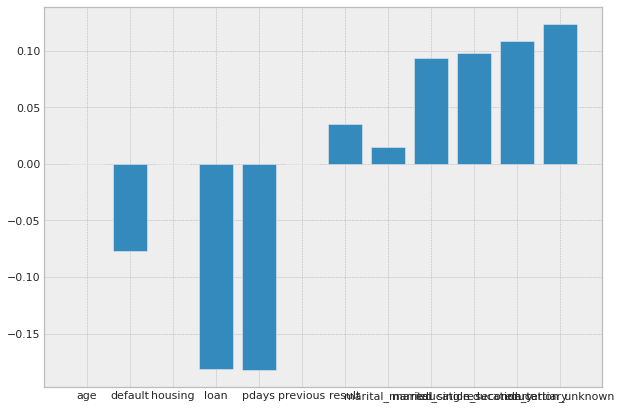

In [ ]:
# パラメータの分布をヒストグラムで可視化
plt.figure(figsize=(10, 7))
plt.bar(x=columns, height=model.coef_);

In [ ]:
# 学習後のバイアス b
model.intercept_

0.40515339334859274

In [ ]:
# Step 3：モデルの検証
print('train score : ', model.score(x_train, t_train))
print('val score : ', model.score(x_val, t_val))

train score :  -1.1467749500406659
val score :  -1.2640044138903987


In [ ]:
y_pred = model.predict(x_test)

In [ ]:
np.unique(y_pred)

array([-0.02396729, -0.02189322, -0.01802724, ...,  1.43950273,
        1.54062591,  1.71597065])

## Lasso回帰

In [ ]:
# モデルの定義
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1)

# モデルの学習
lasso.fit(x_train_oversampled, t_train_oversampled)

Lasso(alpha=1)

In [ ]:
# モデルの検証
print('train score : ', lasso.score(x_train, t_train))
print('val score : ', lasso.score(x_val, t_val))

train score :  -1.3294551213597567
val score :  -1.4060681010622353


In [ ]:
y_pred = lasso.predict(x_test)
y_pred

array([0.46789971, 0.44810188, 0.44065373, ..., 0.45541311, 0.5311405 ,
       0.45467377])

## PLS回帰（部分的最小二乗回帰）

In [ ]:
# モデルの定義
from sklearn.cross_decomposition import PLSRegression
pls = PLSRegression(n_components=2)

# モデルの学習
pls.fit(x_train_oversampled, t_train_oversampled)

PLSRegression()

In [ ]:
# モデルの検証
print('train score : ', pls.score(x_train, t_train))
print('val score : ', pls.score(x_val, t_val))

train score :  -1.149073034292067
val score :  -1.2784247394154193


In [ ]:
y_pred = pls.predict(x_test)
y_pred

array([[0.35949104],
       [0.34598898],
       [0.33050569],
       ...,
       [0.51587064],
       [0.54343215],
       [0.52692305]])

## 決定木

In [ ]:
# モデルの定義
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(random_state=0) 

# モデルの学習
dtree.fit(x_train_oversampled, t_train_oversampled)

# モデルの検証
print('train score：', dtree.score(x_train, t_train)) # 決定木のscore()メソッド：正解率
print('val score：', dtree.score(x_val, t_val))

train score： 0.9988489871086557
val score： 0.8191089640365002


In [ ]:
# 推論
y_pred = dtree.predict(x_test)
y_pred

array([0, 0, 0, ..., 0, 0, 1])

In [ ]:
np.unique(y_pred, return_counts=True)

(array([0, 1]), array([13189,  1811]))

In [ ]:
recall = metrics.recall_score(t_test, y_pred, average=None)
recall

array([0.90862407, 0.34186576])

## サポートベクトルマシン

In [ ]:
from math import gamma
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()

# fitメソッドを用いて、データセットの平均と標準偏差を算出
std_scaler.fit(x_train_oversampled)

# 標準化（算出した平均と標準偏差をから実際の値を変換：transform()メソッド）
x_train_std = std_scaler.transform(x_train_oversampled)
x_test_std = std_scaler.transform(x_val_oversampled)

# 平均（round(f, 1)でfを小数第1（デフォルト：0）位まで四捨五入して表示）
print(round(x_train_std.mean(), 1)) 
# 標準偏差
print(round(x_train_std.std()))

# モデルの定義
from sklearn.svm import SVC
svc = SVC(C=1.0, gamma='auto')

# モデルの学習
svc.fit(x_train_std, t_train_oversampled)

# モデルの検証
print('train score：', svc.score(x_train, t_train))
print('val score : ', svc.score(x_val, t_val))

-0.0
1
train score： 0.8825966850828729
val score :  0.8872785829307569


In [ ]:
# 推論
y_pred = svc.predict(x_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
np.unique(y_pred, return_counts=True)

(array([0]), array([15000]))

In [ ]:
recall = metrics.recall_score(t_test, y_pred, average=None)
recall

array([1., 0.])

## ロジスティック回帰

In [ ]:
# モデルの定義
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(C=1.0)

# モデルの学習
log_reg.fit(x_train_oversampled, t_train_oversampled)

# モデルの検証
print('train score : ', log_reg.score(x_train, t_train))
print('val score : ', log_reg.score(x_val, t_val))

train score :  0.6560773480662984
val score :  0.6468062265163714


In [ ]:
log_reg.coef_.shape

(1, 12)

In [ ]:
# 重み（係数）
log_reg.coef_

array([[ 5.18785515e-03, -3.54594775e-02,  4.06328580e-05,
        -7.66759135e-01, -3.85311107e-01,  1.35407998e-03,
         2.19164588e-01, -2.54479173e-01,  2.41688132e-01,
        -4.81732267e-02,  1.39310347e-01,  5.36812629e-02]])

In [ ]:
# 切片
log_reg.intercept_

array([-0.06495078])

In [ ]:
# 推論
y_pred = log_reg.predict(x_test)
y_pred

array([0, 0, 0, ..., 1, 1, 0])

In [ ]:
np.unique(t_test, return_counts=True)

(array([0, 1]), array([13242,  1758]))

In [ ]:
recall = metrics.recall_score(t_test, y_pred, average=None)
recall

array([0.65783114, 0.61205916])

## ランダムフォレスト

In [ ]:
# モデルの定義
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=3, max_depth=2, random_state=0)

In [ ]:
# モデルの学習
model.fit(x_train_oversampled, t_train_oversampled)

RandomForestClassifier(max_depth=2, n_estimators=3, random_state=0)

In [ ]:
# モデルの検証
print('train score : ', model.score(x_train, t_train))
print('val score : ', model.score(x_val, t_val))

train score :  0.623158379373849
val score :  0.607085346215781


In [ ]:
# 特徴量重要度の確認
model.feature_importances_

array([0.        , 0.        , 0.        , 0.35964894, 0.16462321,
       0.        , 0.09862785, 0.14803438, 0.1815591 , 0.        ,
       0.04750652, 0.        ])

In [ ]:
# 推論
y_pred = model.predict(x_test)
y_pred

array([0, 0, 0, ..., 1, 0, 0])

In [ ]:
np.unique(y_pred, return_counts=True)

(array([0, 1]), array([9054, 5946]))

In [ ]:
recall = metrics.recall_score(t_test, y_pred, average=None)
recall

array([0.62815285, 0.58134243])

## XGBoost

In [ ]:
# モデルの定義
from xgboost import XGBClassifier
model = XGBClassifier(learning_rate=0.001)

# モデルの学習
model.fit(x_train_oversampled, t_train_oversampled)

# モデルの検証
print('train score : ', model.score(x_train, t_train))
print('val score : ', model.score(x_test, t_test))

train score :  0.8535911602209945
val score :  0.8454666666666667


In [ ]:
# 推論
y_pred = model.predict(x_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
np.unique(y_pred, return_counts=True)

(array([0, 1]), array([13520,  1480]))

In [ ]:
recall = metrics.recall_score(t_test, y_pred, average=None)
recall

array([0.92297236, 0.26166098])

## PyTorch

In [ ]:
x_oversampled = torch.tensor(x_train_val_oversampled, dtype=torch.float32)
t_oversampled = torch.tensor(t_train_val_oversampled, dtype=torch.int64)

In [ ]:
# 入力値と目標値をまとめる
dataset = torch.utils.data.TensorDataset(x_oversampled, t_oversampled)

# 各データセットのサンプル数を決定
# train : val = 70% : 30% 
n_train = int(len(dataset) * 0.7)
n_val = len(dataset) - n_train
#n_test = len(dataset) - n_train - n_val

# ランダムに分割を行うため、シードを固定して再現性を確保
pl.seed_everything(0)

# データセットの分割
train, val = torch.utils.data.random_split(dataset, [n_train, n_val])

# バッチサイズの定義
batch_size = 45

# Data Loader を用意
# shuffle はデフォルトで False のため、訓練データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val, batch_size)
#test_loader = torch.utils.data.DataLoader(test, batch_size)

Global seed set to 0


In [ ]:
n_train, n_val

(7681, 3293)

In [ ]:
class Net(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.bn0 = nn.BatchNorm1d(12)
        self.fc1 = nn.Linear(12, 53) 
        self.bn1 = nn.BatchNorm1d(53)
        self.fc2 = nn.Linear(53, 17)
        self.bn2 = nn.BatchNorm1d(17)
        self.fc3 = nn.Linear(17, 11)
        self.bn3 = nn.BatchNorm1d(11)
        self.fc4 = nn.Linear(11, 2)


    def forward(self, x):
        h = self.bn0(x)
        h = self.fc1(h)
        h = F.relu(h)
        h = self.bn1(h)
        h = self.fc2(h)
        h = F.relu(h)
        h = self.bn2(h)
        h = self.fc3(h)
        h = self.bn3(h)
        h = self.fc4(h)
        return F.sigmoid(h)


    def training_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', accuracy(y.softmax(dim=-1), t), on_step=True, on_epoch=True, prog_bar=True)
        return loss


    # 検証データに対する処理
    def validation_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        self.log('val_acc', accuracy(y.softmax(dim=-1), t), on_step=False, on_epoch=True)
        return loss


    # テストデータに対する処理
    #def test_step(self, batch, batch_idx):
    #    x, t = batch
    #    y = self(x)
    #    loss = F.cross_entropy(y, t)
    #    self.log('test_loss', loss, on_step=False, on_epoch=True)
    #    self.log('test_acc', accuracy(y.softmax(dim=-1), t), on_step=False, on_epoch=True)
    #    return loss


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001, weight_decay=0.5)
        return optimizer

In [ ]:
# GPU を含めた乱数のシードを固定
pl.seed_everything(0)

# 定義したクラスをインスタンス化
net = Net()

# 学習
logger = CSVLogger(save_dir='logs', name='my_exp')
trainer = pl.Trainer(callbacks=[EarlyStopping(monitor='val_acc')], max_epochs=10, deterministic=True, logger=logger)# 
# GPU を使用する場合
# trainer = pl.Trainer(max_epochs=30, gpus=1, deterministic=True, logger=logger)

# 学習の実行
trainer.fit(net, train_loader, val_loader)

Global seed set to 0
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name | Type        | Params
-------------------------------------
0 | bn0  | BatchNorm1d | 24    
1 | fc1  | Linear      | 689   
2 | bn1  | BatchNorm1d | 106   
3 | fc2  | Linear      | 918   
4 | bn2  | BatchNorm1d | 34    
5 | fc3  | Linear      | 198   
6 | bn3  | BatchNorm1d | 22    
7 | fc4  | Linear      | 24    
-------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 0


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
trainer.callback_metrics

{'train_acc': tensor(0.7418),
 'train_acc_epoch': tensor(0.7418),
 'train_acc_step': tensor(0.6667),
 'train_loss': tensor(0.6773),
 'train_loss_epoch': tensor(0.6773),
 'train_loss_step': tensor(0.6843),
 'val_acc': tensor(0.7540),
 'val_loss': tensor(0.6816)}

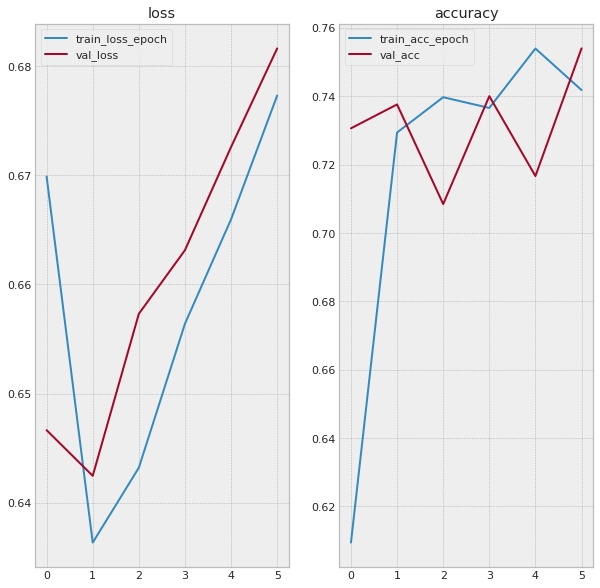

In [ ]:
# 学習ログの取得
log = pd.read_csv('/content/logs/my_exp/version_0/metrics.csv')

# loss
plt.subplot(1, 2, 1)
log[['train_loss_epoch', 'epoch']].dropna(how='any', axis=0).reset_index()['train_loss_epoch'].plot();
log[['val_loss', 'epoch']].dropna(how='any', axis=0).reset_index()['val_loss'].plot();
plt.title('loss')
plt.legend()

# accuracy
plt.subplot(1, 2, 2)
log[['train_acc_epoch', 'epoch']].dropna(how='any', axis=0).reset_index()['train_acc_epoch'].plot();
log[['val_acc', 'epoch']].dropna(how='any', axis=0).reset_index()['val_acc'].plot();
plt.title('accuracy')
plt.legend()

In [ ]:
# 保存
torch.save(net.state_dict(), 'weight.pt')

In [ ]:
class Net(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.bn0 = nn.BatchNorm1d(12)
        self.fc1 = nn.Linear(12, 53) 
        self.bn1 = nn.BatchNorm1d(53)
        self.fc2 = nn.Linear(53, 17)
        self.bn2 = nn.BatchNorm1d(17)
        self.fc3 = nn.Linear(17, 11)
        self.bn3 = nn.BatchNorm1d(11)
        self.fc4 = nn.Linear(11, 2)


    def forward(self, x):
        h = self.bn0(x)
        h = self.fc1(h)
        h = F.relu(h)
        h = self.bn1(h)
        h = self.fc2(h)
        h = F.relu(h)
        h = self.bn2(h)
        h = self.fc3(h)
        h = self.bn3(h)
        h = self.fc4(h)
        return F.sigmoid(h)

# インスタンス化
net = Net().cpu().eval()

# 重みのロード
net.load_state_dict(torch.load('weight.pt'))

<All keys matched successfully>

In [ ]:
test = torch.tensor(x_test, dtype=torch.float32)
t_train_test = []
y_pred = []
TP = 0
FN = 0
count = 0
count_acc = 0
for i in range(len(test)):
    x_train_test = test[i]
    t_train_test.append(t_test[i])
    # 予測値の算出
    with torch.no_grad():
        y = net(x_train_test.unsqueeze(0))
    
    # 確率値に変換
    y = F.softmax(y, dim=1)
    y = y.flatten()

    # 予測ラベル（閾値:0.4854)
    if (y[1] > 0.4854):
        y = 1
    else:
        y = 0
    y_pred.append(int(y)) 

    # Recall（再現率）の計算
    if (y_pred[i] == 1) and (t_test[i] == 1):
        TP = TP + 1
    if (y_pred[i] == 0) and (t_test[i] == 1):
        FN = FN + 1

    # Accuracy（正解率)
    if (y_pred[i] == t_test[i]):
        count_acc += 1 
print('Accuracy:', count_acc / 15000)
print('TP:', TP, ' FN:', FN)
Recall = TP / (TP + FN)
print('Recall:', Recall)
print(y_pred)
print(t_train_test)

Accuracy: 0.20593333333333333
TP: 1653  FN: 105
Recall: 0.9402730375426621
[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 

In [ ]:
np.unique(y_pred, return_counts=True)

(array([0, 1]), array([ 1541, 13459]))

In [ ]:
np.unique(t_test, return_counts=True)

(array([0, 1]), array([13242,  1758]))

In [ ]:
recall = metrics.recall_score(t_test, y_pred, average=None)
recall

array([0.10844283, 0.94027304])